In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import neuromaps
from neuromaps import datasets, transforms, images, resampling, nulls, stats
from scipy.stats import pearsonr, spearmanr, zscore, rankdata
from statsmodels.stats.multitest import multipletests
import math

In [3]:
print("neuromaps version:", neuromaps.__version__)

neuromaps version: 0.0.5+41.gf0ed67c


In [4]:
!wb_command -version

Connectome Workbench
Type: Command Line Application
Version: 2.0.1
Qt Compiled Version: 6.2.3
Qt Runtime Version: 6.2.3
Commit: 150de12f4f4b94b39bec6d9133ad2e7019d2d3ef
Commit Date: 2024-10-15 17:38:41 -0500
Compiler: c++ (/Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin)
Compiler Version: 13.0.0.13000029
Compiled Debug: NO
Operating System: Apple OSX
Compiled with OpenMP: YES


In [19]:
## Preprocessing brain data

brain_maps = [
    {'source': 'abagen', 'desc': 'genepc1', 'space': 'fsaverage', 'den': '10k'},
    {'source': 'hcps1200', 'desc': 'myelinmap', 'space': 'fsLR', 'den': '32k'},
    {'source': 'hcps1200', 'desc': 'thickness', 'space': 'fsLR', 'den': '32k'},
    {'source': 'reardon2018', 'desc': 'scalingnih', 'space': 'civet', 'den': '41k'},
    {'source': 'savli2012', 'desc': 'way100635', 'space': 'MNI152', 'res': '3mm'},
    {'source': 'margulies2016', 'desc': 'fcgradient01', 'space': 'fsLR', 'den': '32k'},
    {'source': 'raichle', 'desc': 'cmrglc', 'space': 'fsLR', 'den': '164k'},
    {'source': 'mueller2013', 'desc': 'intersubjvar', 'space': 'fsLR', 'den': '164k'}
]

single_sphere_counter = 0
for map in brain_maps:
    brain_map = datasets.fetch_annotation(**map)
    if len(brain_map) != 2:
        single_sphere_counter += 1
        print(map)
print(single_sphere_counter)

readable_map_names = {
    'genepc1': 'PC1 Gene Expression',
    'myelinmap': 'T1w/T2w Ratio',
    'thickness': 'Cortical Thickness',
    'fcgradient01': 'Functional Gradient',
    'intersubjvar': 'Intersubject Variability',
    'cmrglc': 'Glucose Metabolism',
    'scalingnih': 'Allometric Scaling (NIH)',
    'way100635':' 5-HT1A Receptor'
}


[References] Please cite the following papers if you are using this data:

  For {'source': 'abagen', 'desc': 'genepc1', 'space': 'fsaverage', 'den': '10k'}:
  [primary]:
    Michael J Hawrylycz, Ed S Lein, Angela L Guillozet-Bongaarts, Elaine H Shen, Lydia Ng, Jeremy A Miller, Louie N Van De Lagemaat, Kimberly A Smith, Amanda Ebbert, Zackery L Riley, and others. An anatomically comprehensive atlas of the adult human brain transcriptome. Nature, 489(7416):391, 2012.
    Ross D Markello, Aurina Arnatkeviciute, Jean-Baptiste Poline, Ben D Fulcher, Alex Fornito, and Bratislav Misic. Standardizing workflows in imaging transcriptomics with the abagen toolbox. eLife, 10:e72129, 2021.
  [secondary]:
    

[References] Please cite the following papers if you are using this data:

  For {'source': 'hcps1200', 'desc': 'myelinmap', 'space': 'fsLR', 'den': '32k'}:
  [primary]:
    Matthew F Glasser, Timothy S Coalson, Emma C Robinson, Carl D Hacker, John Harwell, Essa Yacoub, Kamil Ugurbil, Jespe

In [20]:
def is_volumetric(map_dict):
    """Check if a map is volumetric (MNI space)"""
    return map_dict.get('space') in ['MNI152', 'MNI305']

## Load and transform the dara
def load_and_prepare_map(map_dict, readable_map_names=None, target_space='fsLR', target_den='32k'):
    """
    Load a brain map and prepare it for analysis
    - Volumetric maps: transform to surface
    - Surface maps: resample if needed, use both hemispheres
    - return (transformed data array, space, density)
    """
    # Determine display name for logging
    desc = map_dict['desc']
    if readable_map_names and desc in readable_map_names:
        display_name = readable_map_names[desc]
    else:
        display_name = desc
    
    # Fetch the map
    brain_map = datasets.fetch_annotation(**map_dict)
    
    # Check if volumetric
    if is_volumetric(map_dict):
        print(f"Volumetric map detected, transforming to {target_space} surface...")
        
        # Transform volumetric to surface (both hemispheres)
        try:
            surface_map = transforms.mni152_to_fslr(brain_map, fslr_density=target_den)
            # surface_map will be a tuple of (left_hemi, right_hemi)
            lh_data = images.load_data(surface_map[0])
            rh_data = images.load_data(surface_map[1])
            full_data = np.hstack([lh_data, rh_data])
            return full_data, target_space, target_den
            
        except Exception as e:
            print(f"    Warning: Could not transform volumetric map: {e}")
 
    # Surface map processing
    else:
        src_space = map_dict.get('space')
        src_den = map_dict.get('den')
        template = {'source': 'hcps1200', 'desc': 'thickness', 'space': 'fsLR', 'den': '32k'}
        template_map = datasets.fetch_annotation(**template)
        # Load both hemispheres
        if len(brain_map) == 2:
            lh_map, rh_map = brain_map
        else:
            raise ValueError(f"Expected 2 hemispheres for surface map, got {len(brain_map)}")
        
        if src_den != target_den or src_space != target_space:
            print(f"Resampling from {src_space}-{src_den} to {target_space}-{target_den}...")            
            # Resample both hemispheres
            lh_resampled, _ = resampling.resample_images(
                lh_map, template_map[0],
                src_space=src_space, trg_space=target_space,
                hemi='L', resampling='transform_to_trg'
            )
            rh_resampled, _ = resampling.resample_images(
                rh_map, template_map[1],
                src_space=src_space, trg_space=target_space,
                hemi='R', resampling='transform_to_trg'
            )
            
            lh_data = images.load_data(lh_resampled)
            rh_data = images.load_data(rh_resampled)
        else:
            lh_data = images.load_data(lh_map)
            rh_data = images.load_data(rh_map)
        
        full_data = np.hstack([lh_data, rh_data])
        return full_data, src_space if src_den == target_den else target_space, \
               src_den if src_den == target_den else target_den

In [78]:
## Compute heat map correlation matrix

def compute_preliminary_matrix(prepared_maps, map_names, nulls_list, n_perm=1000, readable_map_names=None):
    """
    - prepared_maps: List of numpy arrays (N_vertices,) for each map.
    - map_names: List of strings naming each map.
    - nulls_list: List of null arrays (N_vertices, n_perm) for each map.
    - n_perm: Number of permutations used (default 1000).
    - readable_map_names: Dictionary mapping map keys (desc) to readable strings.
    """
    
    data_stack = np.column_stack(prepared_maps)
    
    # Global Mask: Remove vertices where ANY map is missing data
    global_mask = np.all((~np.isnan(data_stack)) & (data_stack != 0), axis=1)
    
    clean_data = data_stack[global_mask]
    n_vertices_clean = clean_data.shape[0]
    
    # Z-Score to standardize units (Correlation == Covariance)
    clean_data_z = zscore(clean_data, axis=0)
    
    real_corr = (clean_data_z.T @ clean_data_z) / n_vertices_clean

    p_counts = np.zeros((len(prepared_maps), len(prepared_maps)))
    
    clean_nulls_list = [n[global_mask, :] for n in nulls_list]
    
    for k in range(n_perm):
        if k % 100 == 0: print(f"Permutation {k}/{n_perm}...")
        
        null_data_k = np.zeros_like(clean_data_z)
        for m in range(len(prepared_maps)):
            spin_k = clean_nulls_list[m][:, k]
            null_data_k[:, m] = zscore(spin_k, nan_policy='omit')
            
        null_corr_k = np.corrcoef(null_data_k.T)
        
        # Check: Is random correlation stronger than real correlation?
        is_stronger = np.abs(null_corr_k) >= np.abs(real_corr)
        p_counts += is_stronger.astype(int)

    p_values = (p_counts + 1) / (n_perm + 1)
    
    # Resolve readable names for the DataFrame columns/indices
    display_names = map_names
    if readable_map_names is not None:
        display_names = []
        for name in map_names:
            if name in readable_map_names:
                display_names.append(readable_map_names[name])
                continue
            found_match = False
            for key, val in readable_map_names.items():
                if name.endswith(f"_{key}"):
                    display_names.append(val)
                    found_match = True
                    break
            
            if not found_match:
                display_names.append(name)
    
    df_corr = pd.DataFrame(real_corr, index=display_names, columns=display_names).round(3)
    df_pvals = pd.DataFrame(p_values, index=display_names, columns=display_names).round(3)
    
    # Mask non-significant values (p > 0.05)
    df_significant = df_corr.copy()
    df_significant[df_pvals > 0.05] = 0
    
    return df_corr, df_pvals, df_significant


## Function to plot heatmaps
def plot_correlation_heatmaps(df_corr, df_significant, method=None):
    """
    Plots two side-by-side heatmaps: 
    1. The Full Correlation Matrix
    2. The Significant-Only Matrix (Non-significant cells masked)
    """
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    sns.heatmap(
        df_corr, 
        annot=True, 
        fmt=".2f", 
        cmap='RdBu_r', 
        center=0, 
        vmin=-1, vmax=1,
        square=True,
        ax=axes[0],
        cbar_kws={'label': method}
    )
    axes[0].set_title("Full Correlation Matrix (Raw)", fontsize=16)
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].tick_params(axis='y', rotation=0)
    
    # plot matrix masked
    mask = (df_significant == 0)
    
    sns.heatmap(
        df_significant, 
        annot=True, 
        fmt=".2f", 
        cmap='RdBu_r', 
        center=0, 
        vmin=-1, vmax=1,
        square=True,
        mask=mask, # hide non significant cells
        ax=axes[1],
        cbar_kws={'label': method}
    )
    axes[1].set_title("Significant Correlations Only (p < 0.05)", fontsize=16)
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].tick_params(axis='y', rotation=0)
    
    plt.tight_layout()
    plt.show()

In [ ]:
## Funciton to plot EDA pairwise scatter plots 

def plot_pairwise_scatterplots(prepared_maps, map_names, readable_map_names=None):
    # data prep
    # 32k rows 8 columns
    data_stack = np.column_stack(prepared_maps)
    global_mask = np.all((~np.isnan(data_stack)) & (data_stack != 0), axis=1) # get rid of NaNs
    clean_data = data_stack[global_mask]
    
    n_maps = len(prepared_maps)
    
    # making sure brain maps names exist and are readable
    # uses readable names instead of desc name
    display_names = map_names
    if readable_map_names:
        display_names = []
        for name in map_names:
            if name in readable_map_names:
                display_names.append(readable_map_names[name])
                continue
            found_match = False
            for key, val in readable_map_names.items():
                if name.endswith(f"_{key}"):
                    display_names.append(val)
                    found_match = True
                    break
            if not found_match:
                display_names.append(name)

    # 28 unique pairs
    n_pairs = (n_maps * (n_maps - 1)) // 2
    n_cols = 4
    n_rows = math.ceil(n_pairs / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
    axes = axes.flatten()
    
    plot_idx = 0
    
    for i in range(n_maps):
        for j in range(i + 1, n_maps):
            ax = axes[plot_idx]
            
            x = clean_data[:, i] # column i for all j rows
            y = clean_data[:, j]
            r, _ = pearsonr(x, y)
            rho, _ = spearmanr(x, y)
            # use hexbin for density instead of scatter plot because of ~32k points
            hb = ax.hexbin(x, y, gridsize=50, cmap='Blues', mincnt=1, bins='log')
            # add trend line
            z = np.polyfit(x, y, 1)
            p = np.poly1d(z)
            x_range = np.linspace(x.min(), x.max(), 100)
            ax.plot(x_range, p(x_range), "r--", alpha=0.8, linewidth=2)
            
            ax.set_xlabel(display_names[i], fontsize=8)
            ax.set_ylabel(display_names[j], fontsize=8)
            
            # Green if metrics agree (diff < 0.1), Red if they diverge
            diff = abs(r - rho)
            title_color = 'green' if diff < 0.1 else 'red'
            
            ax.set_title(f"r={r:.2f} | ρ={rho:.2f}", fontsize=10, color=title_color, fontweight='bold')
            ax.set_xticks([])
            ax.set_yticks([])
            
            plot_idx += 1
        
    for k in range(plot_idx, len(axes)):
        axes[k].axis('off')
        
    plt.tight_layout()
    plt.show()

In [ ]:
## RUN THIS 
# takes about 12 min to run

prepared_maps = []
map_names = []
nulls_list = []
n_perm = 1000

for i, b_map in enumerate(brain_maps):
    prep_data, _, _ = load_and_prepare_map(
                                            b_map, 
                                            readable_map_names=readable_map_names, 
                                            target_space='fsLR', 
                                            target_den='32k')
    prepared_maps.append(prep_data)

    name = f"{b_map['source']}_{b_map['desc']}"
    map_names.append(name)

    desc = b_map['desc']
    display_name = readable_map_names.get(desc, desc)
    
    rotated = nulls.alexander_bloch(
        prep_data, 
        atlas='fsLR', 
        density='32k', 
        n_perm=n_perm, 
        seed=1234 + i 
    )
    nulls_list.append(rotated)


[References] Please cite the following papers if you are using this data:

  For {'source': 'abagen', 'desc': 'genepc1', 'space': 'fsaverage', 'den': '10k'}:
  [primary]:
    Michael J Hawrylycz, Ed S Lein, Angela L Guillozet-Bongaarts, Elaine H Shen, Lydia Ng, Jeremy A Miller, Louie N Van De Lagemaat, Kimberly A Smith, Amanda Ebbert, Zackery L Riley, and others. An anatomically comprehensive atlas of the adult human brain transcriptome. Nature, 489(7416):391, 2012.
    Ross D Markello, Aurina Arnatkeviciute, Jean-Baptiste Poline, Ben D Fulcher, Alex Fornito, and Bratislav Misic. Standardizing workflows in imaging transcriptomics with the abagen toolbox. eLife, 10:e72129, 2021.
  [secondary]:
    

[References] Please cite the following papers if you are using this data:

  For {'source': 'hcps1200', 'desc': 'thickness', 'space': 'fsLR', 'den': '32k'}:
  [primary]:
    Matthew F Glasser, Timothy S Coalson, Emma C Robinson, Carl D Hacker, John Harwell, Essa Yacoub, Kamil Ugurbil, Jespe

In [72]:
# map_names

In [73]:
# prepared_maps

In [65]:
# If prepared_maps = [array([1, 2, 3]), array([4, 5, 6])]

# data_stack becomes [[1, 4],
#                     [2, 5],
#                     [3, 6]]

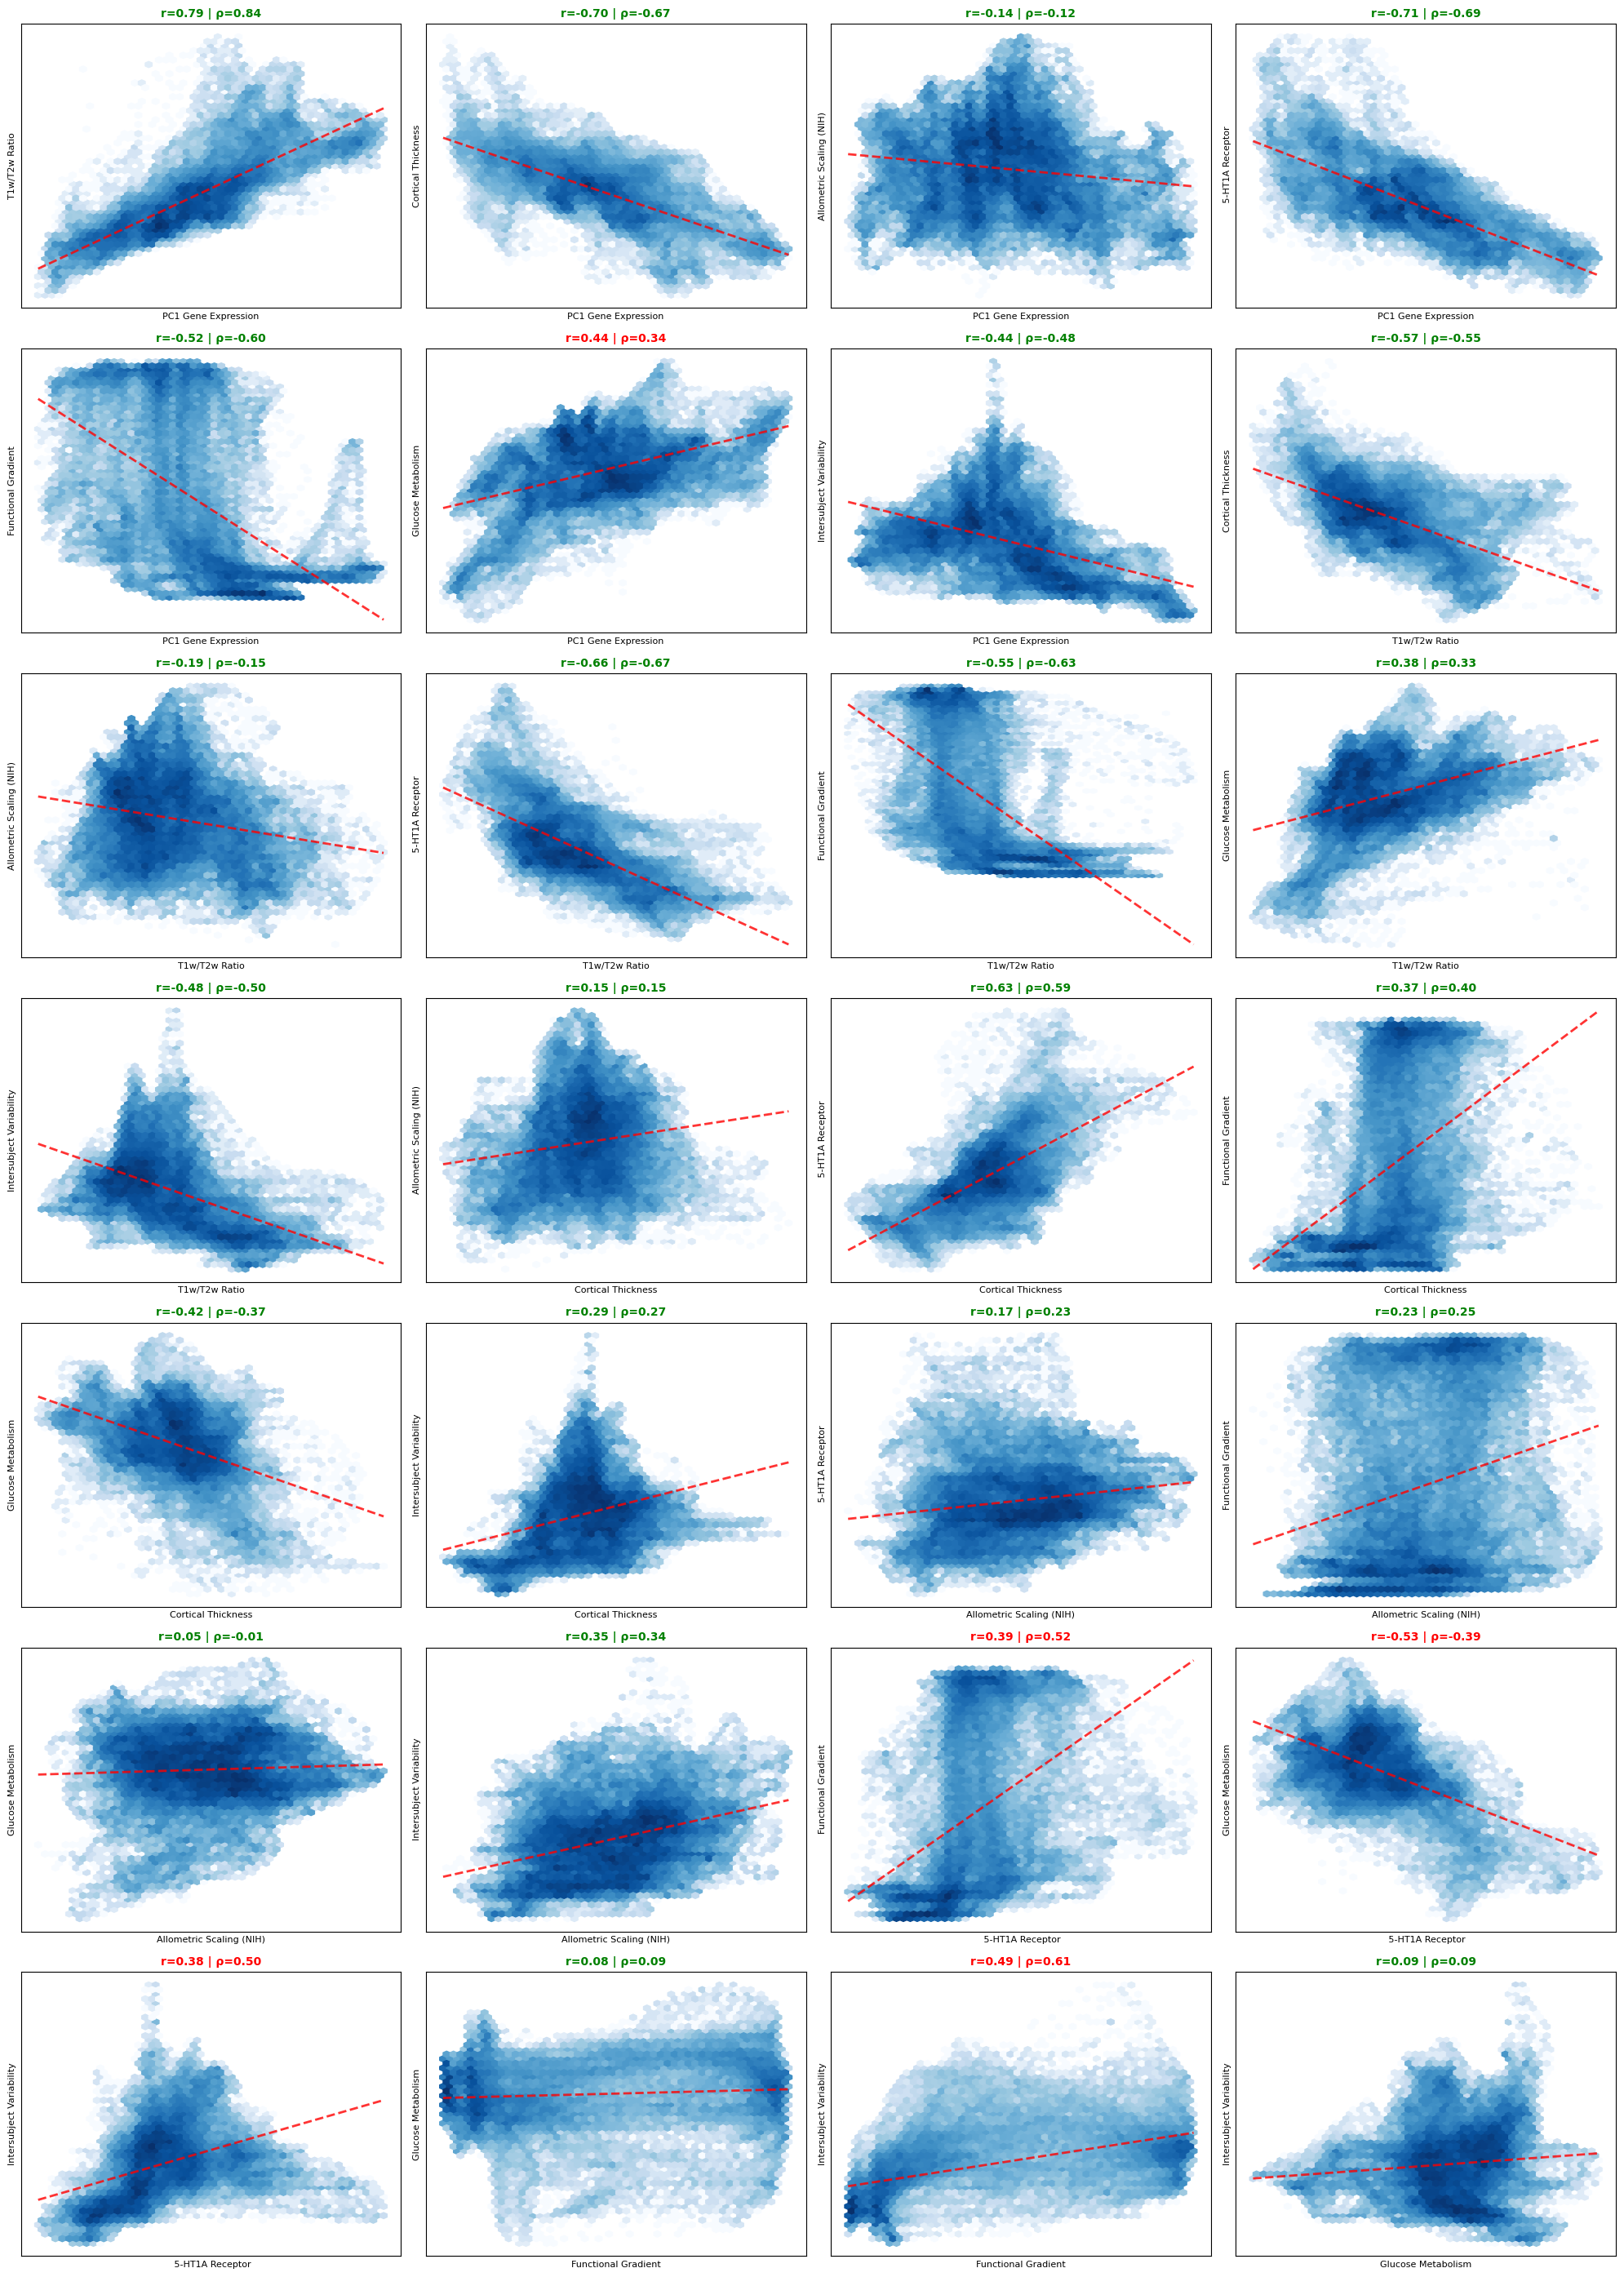

In [ ]:
plot_pairwise_scatterplots(
    prepared_maps, 
    map_names, 
    readable_map_names=readable_map_names
)
# Green title means the the values are similar so we should use pearson
# red titles mean the values are different so we need to look at the hexbin/scatter plot
    # if it's curved or a dark blob with outliers --> use spearman

# for each vertex of the brain, plot the value of map1 vs map2 on the scatter plot

Permutation 0/1000...
Permutation 100/1000...
Permutation 200/1000...
Permutation 300/1000...
Permutation 400/1000...
Permutation 500/1000...
Permutation 600/1000...
Permutation 700/1000...
Permutation 800/1000...
Permutation 900/1000...

--- Correlation Matrix (Pearson r) ---


PC1 Gene Expression  T1w/T2w Ratio  \
PC1 Gene Expression                     1.000          0.793   
T1w/T2w Ratio                           0.793          1.000   
Cortical Thickness                     -0.700         -0.572   
Allometric Scaling (NIH)               -0.142         -0.194   
 5-HT1A Receptor                       -0.708         -0.663   
Functional Gradient                    -0.520         -0.552   
Glucose Metabolism                      0.441          0.381   
Intersubject Variability               -0.436         -0.482   

                          Cortical Thickness  Allometric Scaling (NIH)  \
PC1 Gene Expression                   -0.700                    -0.142   
T1w/T2w Ratio                         -0.572                    -0.194   
Cortical Thickness                     1.000                     0.151   
Allometric Scaling (NIH)               0.151                     1.000   
 5-HT1A Receptor                       0.627                     0.171   
Functional Gradient                    0.373                     0.225   
Glucose Metabolism                    -0.417                     0.048   
Intersubject Variability               0.291                     0.348   

                           5-HT1A Receptor  Functional Gradient  \
PC1 Gene Expression                 -0.708               -0.520   
T1w/T2w Ratio                       -0.663               -0.552   
Cortical Thickness                   0.627                0.373   
Allometric Scaling (NIH)             0.171                0.225   
 5-HT1A Receptor                     1.000                0.394   
Functional Gradient                  0.394                1.000   
Glucose Metabolism                  -0.530                0.084   
Intersubject Variability             0.377                0.494   

                          Glucose Metabolism  Intersubject Variability  
PC1 Gene Expression                    0.441                    -0.436  
T1w/T2w Ratio                          0.381                    -0.482  
Cortical Thickness                    -0.417                     0.291  
Allometric Scaling (NIH)               0.048                     0.348  
 5-HT1A Receptor                      -0.530                     0.377  
Functional Gradient                    0.084                     0.494  
Glucose Metabolism                     1.000                     0.093  
Intersubject Variability               0.093                     1.000


--- Significant Correlations (p < 0.05) ---


PC1 Gene Expression  T1w/T2w Ratio  \
PC1 Gene Expression                     1.000          0.793   
T1w/T2w Ratio                           0.793          1.000   
Cortical Thickness                     -0.700         -0.572   
Allometric Scaling (NIH)               -0.142          0.000   
 5-HT1A Receptor                       -0.708         -0.663   
Functional Gradient                    -0.520         -0.552   
Glucose Metabolism                      0.441          0.000   
Intersubject Variability               -0.436         -0.482   

                          Cortical Thickness  Allometric Scaling (NIH)  \
PC1 Gene Expression                   -0.700                    -0.142   
T1w/T2w Ratio                         -0.572                     0.000   
Cortical Thickness                     1.000                     0.000   
Allometric Scaling (NIH)               0.000                     1.000   
 5-HT1A Receptor                       0.627                     0.000   
Functional Gradient                    0.373                     0.000   
Glucose Metabolism                     0.000                     0.000   
Intersubject Variability               0.000                     0.000   

                           5-HT1A Receptor  Functional Gradient  \
PC1 Gene Expression                 -0.708               -0.520   
T1w/T2w Ratio                       -0.663               -0.552   
Cortical Thickness                   0.627                0.373   
Allometric Scaling (NIH)             0.000                0.000   
 5-HT1A Receptor                     1.000                0.394   
Functional Gradient                  0.394                1.000   
Glucose Metabolism                  -0.530                0.000   
Intersubject Variability             0.000                0.494   

                          Glucose Metabolism  Intersubject Variability  
PC1 Gene Expression                    0.441                    -0.436  
T1w/T2w Ratio                          0.000                    -0.482  
Cortical Thickness                     0.000                     0.000  
Allometric Scaling (NIH)               0.000                     0.000  
 5-HT1A Receptor                      -0.530                     0.000  
Functional Gradient                    0.000                     0.494  
Glucose Metabolism                     1.000                     0.000  
Intersubject Variability               0.000                     1.000

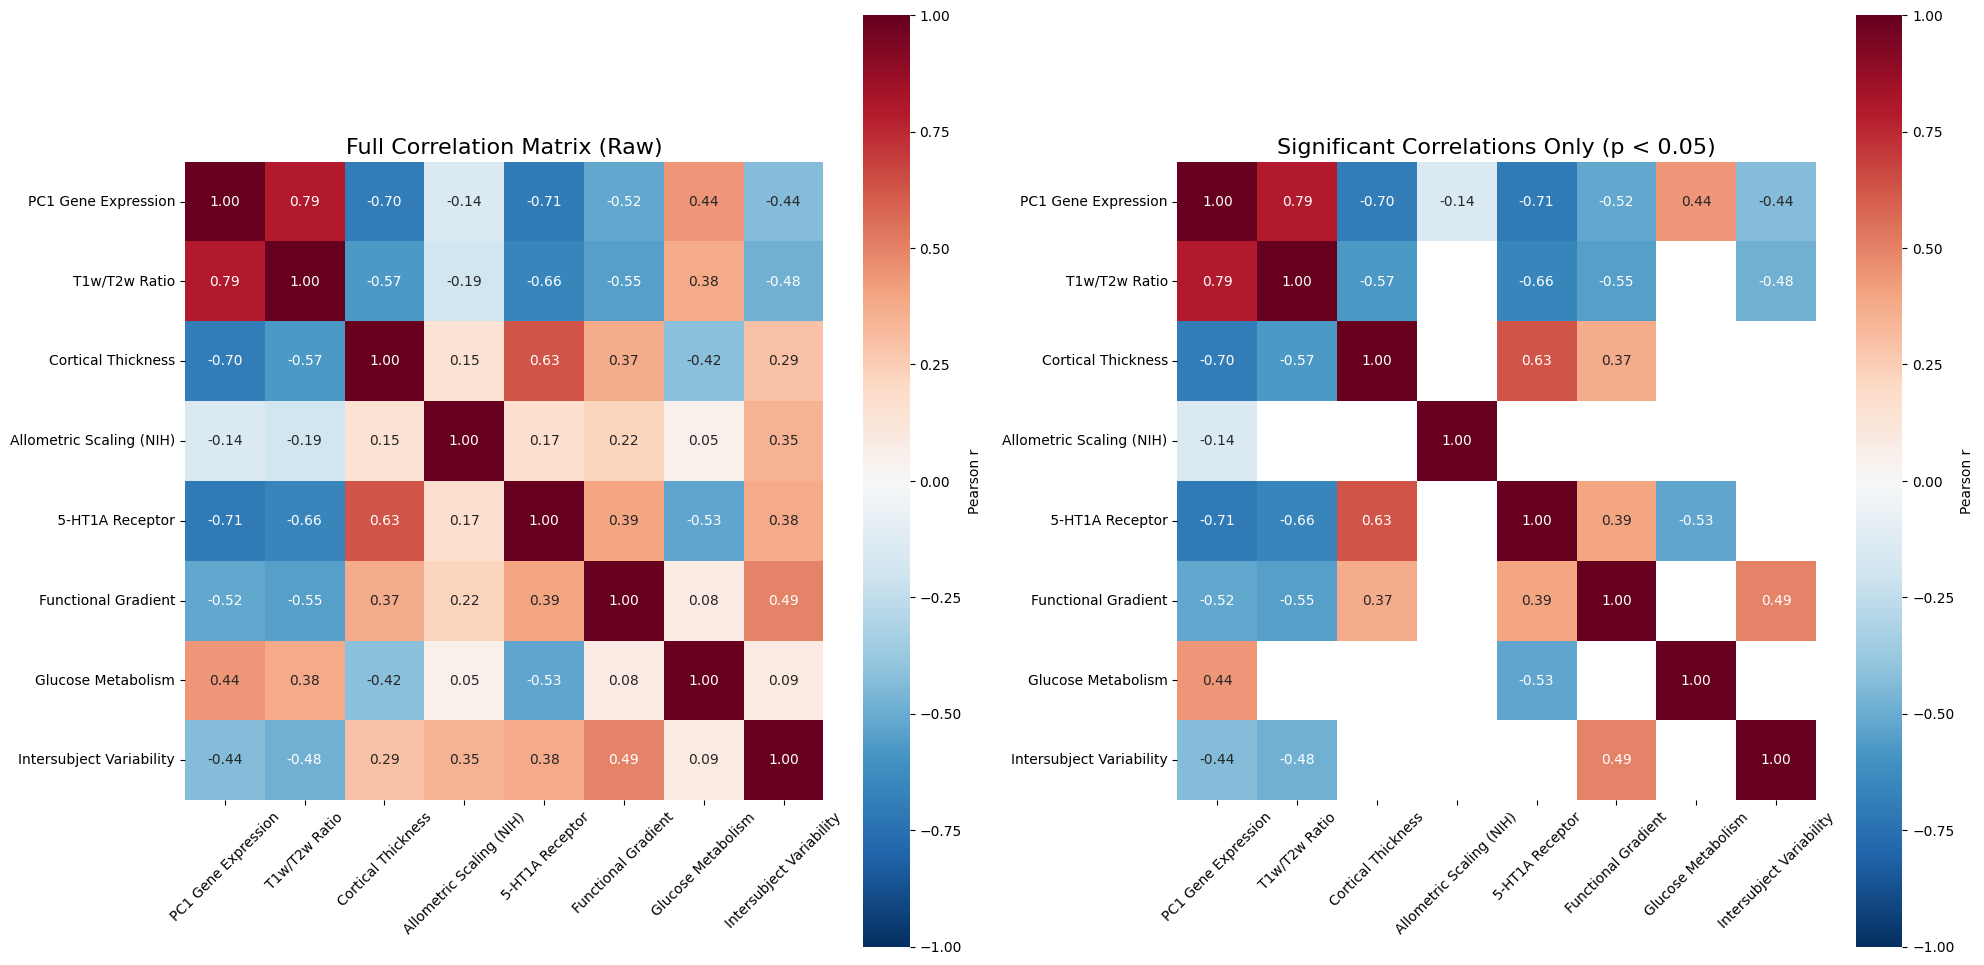

In [ ]:
# Plotting Pearson r Correlation heatmap

df_corr, df_pvals, df_significant = compute_preliminary_matrix(
    prepared_maps, 
    map_names, 
    nulls_list, 
    n_perm=1000,
    readable_map_names=readable_map_names
)

print("\n--- Correlation Matrix (Pearson r) ---")
display(df_corr)

print("\n--- Significant Correlations (p < 0.05) ---")
display(df_significant)

plot_correlation_heatmaps(df_corr, df_significant, method='Pearson r')

In [ ]:
# Plotting Spearman Correlation heatmap

## Spearman Rank
def compute_preliminary_matrix_spearman(prepared_maps, map_names, nulls_list, n_perm=1000, readable_map_names=None):
    """
    correlation matrix using SPEARMAN RANK CORRELATION.
    Use this if your data has non-linear monotonic relationships.
    
    Parameters:
    - prepared_maps: List of numpy arrays (N_vertices,) for each map.
    - map_names: List of strings naming each map.
    - nulls_list: List of null arrays (N_vertices, n_perm) for each map.
    - n_perm: Number of permutations used (default 1000).
    - readable_map_names: Dictionary mapping map keys (desc) to readable strings.
    """

    data_stack = np.column_stack(prepared_maps)

    global_mask = np.all((~np.isnan(data_stack)) & (data_stack != 0), axis=1)
    
    clean_data = data_stack[global_mask]
    n_vertices_clean = clean_data.shape[0]
    
    # TRANSFORMATION FOR SPEARMAN: Rank the data
    # We rank down each column (axis=0)
    # This converts raw values to ranks (1st, 2nd, 3rd...)
    # NOTE: This is where Spearman differs from Pearson
    clean_data_ranked = np.apply_along_axis(rankdata, 0, clean_data)
    
    # Z-Score the RANKS (Standardization)
    # Pearson on Ranks == Spearman on Raw Data
    clean_data_z = zscore(clean_data_ranked, axis=0)
    
    print("\n--- Step 2: Compute Real Correlation Matrix (Spearman) ---")

    real_corr = (clean_data_z.T @ clean_data_z) / n_vertices_clean
    
    print("\n--- Step 3: Compute Spin P-Values (Uncorrected) ---")
    p_counts = np.zeros((len(prepared_maps), len(prepared_maps)))
    
    clean_nulls_list = [n[global_mask, :] for n in nulls_list]
    
    for k in range(n_perm):
        if k % 100 == 0: print(f"Permutation {k}/{n_perm}...")
        
        null_data_k = np.zeros_like(clean_data_z)
        for m in range(len(prepared_maps)):
            spin_k = clean_nulls_list[m][:, k]
            
            # CRITICAL: We must RANK the null data too for valid Spearman comparison
            # Handle NaNs if spins introduced them (though global mask helps)
            spin_k_ranked = rankdata(spin_k, nan_policy='omit')
            
            null_data_k[:, m] = zscore(spin_k_ranked, nan_policy='omit')
            
        null_corr_k = np.corrcoef(null_data_k.T)
        
        # Check: Is random correlation stronger than real correlation?
        is_stronger = np.abs(null_corr_k) >= np.abs(real_corr)
        p_counts += is_stronger.astype(int)

    p_values = (p_counts + 1) / (n_perm + 1)
    
    display_names = map_names
    if readable_map_names is not None:
        display_names = []
        for name in map_names:
            if name in readable_map_names:
                display_names.append(readable_map_names[name])
                continue
            found_match = False
            for key, val in readable_map_names.items():
                if name.endswith(f"_{key}"):
                    display_names.append(val)
                    found_match = True
                    break
            if not found_match:
                display_names.append(name)
    
    df_corr = pd.DataFrame(real_corr, index=display_names, columns=display_names).round(3)
    df_pvals = pd.DataFrame(p_values, index=display_names, columns=display_names).round(3)
    
    # Mask non-significant values (p > 0.05)
    df_significant = df_corr.copy()
    df_significant[df_pvals > 0.05] = 0
    
    return df_corr, df_pvals, df_significant


--- Step 2: Compute Real Correlation Matrix (Spearman) ---

--- Step 3: Compute Spin P-Values (Uncorrected) ---
Permutation 0/1000...
Permutation 100/1000...
Permutation 200/1000...
Permutation 300/1000...
Permutation 400/1000...
Permutation 500/1000...
Permutation 600/1000...
Permutation 700/1000...
Permutation 800/1000...
Permutation 900/1000...

--- Correlation Matrix (Spearman rho) ---


PC1 Gene Expression  T1w/T2w Ratio  \
PC1 Gene Expression                     1.000          0.842   
T1w/T2w Ratio                           0.842          1.000   
Cortical Thickness                     -0.665         -0.553   
Allometric Scaling (NIH)               -0.117         -0.150   
 5-HT1A Receptor                       -0.690         -0.671   
Functional Gradient                    -0.595         -0.629   
Glucose Metabolism                      0.340          0.333   
Intersubject Variability               -0.477         -0.499   

                          Cortical Thickness  Allometric Scaling (NIH)  \
PC1 Gene Expression                   -0.665                    -0.117   
T1w/T2w Ratio                         -0.553                    -0.150   
Cortical Thickness                     1.000                     0.147   
Allometric Scaling (NIH)               0.147                     1.000   
 5-HT1A Receptor                       0.595                     0.225   
Functional Gradient                    0.399                     0.252   
Glucose Metabolism                    -0.366                    -0.013   
Intersubject Variability               0.269                     0.342   

                           5-HT1A Receptor  Functional Gradient  \
PC1 Gene Expression                 -0.690               -0.595   
T1w/T2w Ratio                       -0.671               -0.629   
Cortical Thickness                   0.595                0.399   
Allometric Scaling (NIH)             0.225                0.252   
 5-HT1A Receptor                     1.000                0.519   
Functional Gradient                  0.519                1.000   
Glucose Metabolism                  -0.391                0.092   
Intersubject Variability             0.497                0.612   

                          Glucose Metabolism  Intersubject Variability  
PC1 Gene Expression                    0.340                    -0.477  
T1w/T2w Ratio                          0.333                    -0.499  
Cortical Thickness                    -0.366                     0.269  
Allometric Scaling (NIH)              -0.013                     0.342  
 5-HT1A Receptor                      -0.391                     0.497  
Functional Gradient                    0.092                     0.612  
Glucose Metabolism                     1.000                     0.089  
Intersubject Variability               0.089                     1.000


--- Significant Correlations (p < 0.05) ---


PC1 Gene Expression  T1w/T2w Ratio  \
PC1 Gene Expression                     1.000          0.842   
T1w/T2w Ratio                           0.842          0.000   
Cortical Thickness                     -0.665         -0.553   
Allometric Scaling (NIH)               -0.117          0.000   
 5-HT1A Receptor                       -0.690         -0.671   
Functional Gradient                    -0.595         -0.629   
Glucose Metabolism                      0.340          0.000   
Intersubject Variability               -0.477         -0.499   

                          Cortical Thickness  Allometric Scaling (NIH)  \
PC1 Gene Expression                   -0.665                    -0.117   
T1w/T2w Ratio                         -0.553                     0.000   
Cortical Thickness                     0.000                     0.000   
Allometric Scaling (NIH)               0.000                     1.000   
 5-HT1A Receptor                       0.595                     0.000   
Functional Gradient                    0.399                     0.000   
Glucose Metabolism                     0.000                     0.000   
Intersubject Variability               0.000                     0.342   

                           5-HT1A Receptor  Functional Gradient  \
PC1 Gene Expression                 -0.690               -0.595   
T1w/T2w Ratio                       -0.671               -0.629   
Cortical Thickness                   0.595                0.399   
Allometric Scaling (NIH)             0.000                0.000   
 5-HT1A Receptor                     0.000                0.519   
Functional Gradient                  0.519                1.000   
Glucose Metabolism                   0.000                0.000   
Intersubject Variability             0.497                0.612   

                          Glucose Metabolism  Intersubject Variability  
PC1 Gene Expression                     0.34                    -0.477  
T1w/T2w Ratio                           0.00                    -0.499  
Cortical Thickness                      0.00                     0.000  
Allometric Scaling (NIH)                0.00                     0.342  
 5-HT1A Receptor                        0.00                     0.497  
Functional Gradient                     0.00                     0.612  
Glucose Metabolism                      1.00                     0.000  
Intersubject Variability                0.00                     1.000

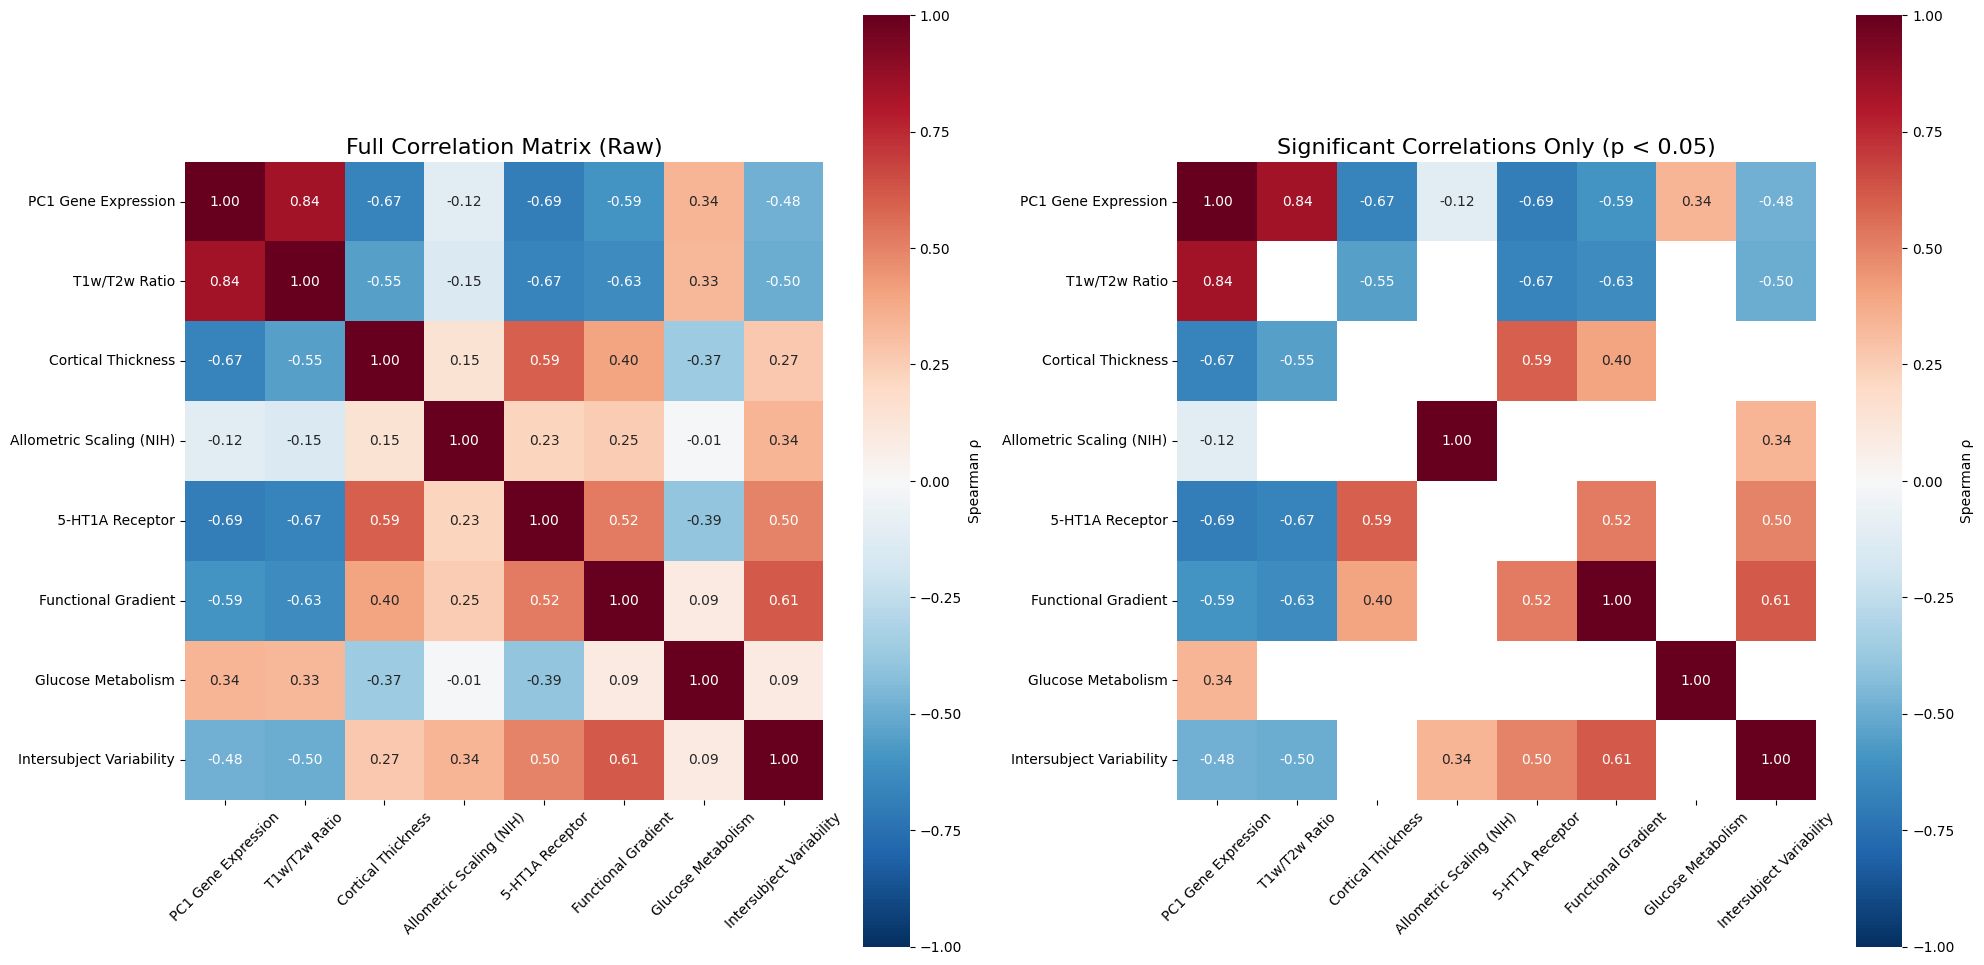

In [79]:
df_corr_spearman, df_pvals_spearman, df_significant_spearman = compute_preliminary_matrix_spearman(
    prepared_maps, 
    map_names, 
    nulls_list, 
    n_perm=1000,
    readable_map_names=readable_map_names
)

print("\n--- Correlation Matrix (Spearman rho) ---")
display(df_corr_spearman)

print("\n--- Significant Correlations (p < 0.05) ---")
display(df_significant_spearman)

plot_correlation_heatmaps(df_corr_spearman, df_significant_spearman, method='Spearman ρ')

### Multiple tests correction

In [ ]:
# Mutltiple Tests correction table
def generate_standard_comparison_table(df_corr, df_pvals, alpha=0.05):
    """
    Computes Bonferroni and FDR BH and FDR BY corrections
    """
    
    mask_tri = np.tril(np.ones(df_pvals.shape), k=-1).astype(bool)
    rows, cols = np.where(mask_tri)
    
    map1_names = df_corr.index[rows]
    map2_names = df_corr.columns[cols]
    
    r_values = df_corr.values[mask_tri]
    p_values_uncorrected = df_pvals.values[mask_tri]
    
    #can use p-val for appendix additional tables
    reject_bonf, pvals_bonf, _, _ = multipletests(p_values_uncorrected, alpha=alpha, method='bonferroni')
    reject_fdr_bh, pvals_fdr_bh, _, _ = multipletests(p_values_uncorrected, alpha=alpha, method='fdr_bh')
    reject_fdr_by, pvals_fdr_by, _, _ = multipletests(p_values_uncorrected, alpha=alpha, method='fdr_by')
    
    results = pd.DataFrame({
        'Map 1': map1_names,
        'Map 2': map2_names,
        'Pearson r': r_values,
        'P-val (Uncorrected)': p_values_uncorrected,
        'Significant (Uncorrected)': p_values_uncorrected < alpha,
        'Significant (Bonf)': reject_bonf,
        'Significant (FDR-BH)': reject_fdr_bh,
        'Significant (FDR-BY)': reject_fdr_by
    })
    
    float_cols = ['Pearson r', 'P-val (Uncorr)']
    results[float_cols] = results[float_cols].round(4)
    
    return results

# Helper function for Max T
def compute_maxt_threshold(prepared_maps, nulls_list, n_perm=1000, method='pearson'):
    """
    Computes the Max-T threshold (FWER)
    """

    data_stack = np.column_stack(prepared_maps)
    global_mask = np.all((~np.isnan(data_stack)) & (data_stack != 0), axis=1)
    
    clean_data = data_stack[global_mask]
    # use this later for additional analysis
    if method == 'spearman':
        clean_data = np.apply_along_axis(rankdata, 0, clean_data)
    
    clean_data_z = zscore(clean_data, axis=0)
    n_vertices_clean = clean_data.shape[0]
    
    clean_nulls_list = [n[global_mask, :] for n in nulls_list]
    max_null_stats = []
    
    for k in range(n_perm):        
        null_data_k = np.zeros_like(clean_data_z)
        for m in range(len(prepared_maps)):
            spin_k = clean_nulls_list[m][:, k]
            if method == 'spearman':
                spin_k = rankdata(spin_k, nan_policy='omit')
            null_data_k[:, m] = zscore(spin_k, nan_policy='omit')
            
        null_corr_matrix = (null_data_k.T @ null_data_k) / n_vertices_clean 
        np.fill_diagonal(null_corr_matrix, 0)
        max_r = np.max(np.abs(null_corr_matrix))
        max_null_stats.append(max_r)
        
    threshold = np.percentile(max_null_stats, 95)
    print(f"Max-T Critical Threshold: r > {threshold:.3f}")
    
    return threshold


# Main function for Max T table
def compute_and_display_maxt(df_corr, prepared_maps, nulls_list, method='pearson'):
    
    n_perm_actual = nulls_list[0].shape[1]
    threshold = compute_maxt_threshold(prepared_maps, nulls_list, n_perm=n_perm_actual, method=method)
    
    # significance mask for final matrix
    maxt_mask = np.abs(df_corr) > threshold
    mask_tri = np.tril(np.ones(df_corr.shape), k=-1).astype(bool)
    rows, cols = np.where(mask_tri)
    
    map1_names = df_corr.index[rows]
    map2_names = df_corr.columns[cols]
    r_values = df_corr.values[rows, cols]
    
    maxt_table = pd.DataFrame({
        'Map 1': map1_names,
        'Map 2': map2_names,
        'Correlation': r_values,
        'Significant': np.abs(r_values) > threshold  # Check if Magnitude > Threshold
    }).round(3)
    display(maxt_table)
    
    # Heat map plot
    plt.figure(figsize=(10, 8))
    df_plot = df_corr.copy()
    df_plot[~maxt_mask] = 0
    np.fill_diagonal(df_plot.values, 1.0)

    visual_mask = (df_plot == 0)
    sns.heatmap(
        df_plot, 
        annot=True, 
        fmt=".2f", 
        cmap='RdBu_r', 
        center=0, 
        vmin=-1, vmax=1,
        square=True,
        mask=visual_mask,
        cbar_kws={'label': f'{method.capitalize()} Correlation'}
    )
    plt.title(f"Significant Couplings (Max-T Corrected)\nThreshold: |r| > {threshold:.3f}", fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return maxt_table, threshold

Map 1                     Map 2  Pearson r  \
0              T1w/T2w Ratio       PC1 Gene Expression      0.842   
1         Cortical Thickness       PC1 Gene Expression     -0.665   
2         Cortical Thickness             T1w/T2w Ratio     -0.553   
3   Allometric Scaling (NIH)       PC1 Gene Expression     -0.117   
4   Allometric Scaling (NIH)             T1w/T2w Ratio     -0.150   
5   Allometric Scaling (NIH)        Cortical Thickness      0.147   
6            5-HT1A Receptor       PC1 Gene Expression     -0.690   
7            5-HT1A Receptor             T1w/T2w Ratio     -0.671   
8            5-HT1A Receptor        Cortical Thickness      0.595   
9            5-HT1A Receptor  Allometric Scaling (NIH)      0.225   
10       Functional Gradient       PC1 Gene Expression     -0.595   
11       Functional Gradient             T1w/T2w Ratio     -0.629   
12       Functional Gradient        Cortical Thickness      0.399   
13       Functional Gradient  Allometric Scaling (NIH)      0.252   
14       Functional Gradient           5-HT1A Receptor      0.519   
15        Glucose Metabolism       PC1 Gene Expression      0.340   
16        Glucose Metabolism             T1w/T2w Ratio      0.333   
17        Glucose Metabolism        Cortical Thickness     -0.366   
18        Glucose Metabolism  Allometric Scaling (NIH)     -0.013   
19        Glucose Metabolism           5-HT1A Receptor     -0.391   
20        Glucose Metabolism       Functional Gradient      0.092   
21  Intersubject Variability       PC1 Gene Expression     -0.477   
22  Intersubject Variability             T1w/T2w Ratio     -0.499   
23  Intersubject Variability        Cortical Thickness      0.269   
24  Intersubject Variability  Allometric Scaling (NIH)      0.342   
25  Intersubject Variability           5-HT1A Receptor      0.497   
26  Intersubject Variability       Functional Gradient      0.612   
27  Intersubject Variability        Glucose Metabolism      0.089   

    P-val (Uncorr)  Sig (Uncorr)  Sig (Bonf)  Sig (FDR-BH)  Sig (FDR-BY)  
0            0.001          True        True          True          True  
1            0.001          True        True          True          True  
2            0.002          True       False          True          True  
3            0.001          True        True          True          True  
4            0.467         False       False         False         False  
5            0.373         False       False         False         False  
6            0.001          True        True          True          True  
7            0.001          True        True          True          True  
8            0.001          True        True          True          True  
9            0.194         False       False         False         False  
10           0.001          True        True          True          True  
11           0.001          True        True          True          True  
12           0.016          True       False          True         False  
13           0.100         False       False         False         False  
14           0.001          True        True          True          True  
15           0.001          True        True          True          True  
16           0.119         False       False         False         False  
17           0.054         False       False         False         False  
18           0.927         False       False         False         False  
19           0.061         False       False         False         False  
20           0.613         False       False         False         False  
21           0.001          True        True          True          True  
22           0.007          True       False          True         False  
23           0.124         False       False         False         False  
24           0.028          True       False          True         False  
25           0.009          True       False          True         Fals

Max-T Critical Threshold: r > nan


Map 1                     Map 2  Correlation  \
0              T1w/T2w Ratio       PC1 Gene Expression        0.842   
1         Cortical Thickness       PC1 Gene Expression       -0.665   
2         Cortical Thickness             T1w/T2w Ratio       -0.553   
3   Allometric Scaling (NIH)       PC1 Gene Expression       -0.117   
4   Allometric Scaling (NIH)             T1w/T2w Ratio       -0.150   
5   Allometric Scaling (NIH)        Cortical Thickness        0.147   
6            5-HT1A Receptor       PC1 Gene Expression       -0.690   
7            5-HT1A Receptor             T1w/T2w Ratio       -0.671   
8            5-HT1A Receptor        Cortical Thickness        0.595   
9            5-HT1A Receptor  Allometric Scaling (NIH)        0.225   
10       Functional Gradient       PC1 Gene Expression       -0.595   
11       Functional Gradient             T1w/T2w Ratio       -0.629   
12       Functional Gradient        Cortical Thickness        0.399   
13       Functional Gradient  Allometric Scaling (NIH)        0.252   
14       Functional Gradient           5-HT1A Receptor        0.519   
15        Glucose Metabolism       PC1 Gene Expression        0.340   
16        Glucose Metabolism             T1w/T2w Ratio        0.333   
17        Glucose Metabolism        Cortical Thickness       -0.366   
18        Glucose Metabolism  Allometric Scaling (NIH)       -0.013   
19        Glucose Metabolism           5-HT1A Receptor       -0.391   
20        Glucose Metabolism       Functional Gradient        0.092   
21  Intersubject Variability       PC1 Gene Expression       -0.477   
22  Intersubject Variability             T1w/T2w Ratio       -0.499   
23  Intersubject Variability        Cortical Thickness        0.269   
24  Intersubject Variability  Allometric Scaling (NIH)        0.342   
25  Intersubject Variability           5-HT1A Receptor        0.497   
26  Intersubject Variability       Functional Gradient        0.612   
27  Intersubject Variability        Glucose Metabolism        0.089   

    Significant  
0         False  
1         False  
2         False  
3         False  
4         False  
5         False  
6         False  
7         False  
8         False  
9         False  
10        False  
11        False  
12        False  
13        False  
14        False  
15        False  
16        False  
17        False  
18        False  
19        False  
20        False  
21        False  
22        False  
23        False  
24        False  
25        False  
26        False  
27        False

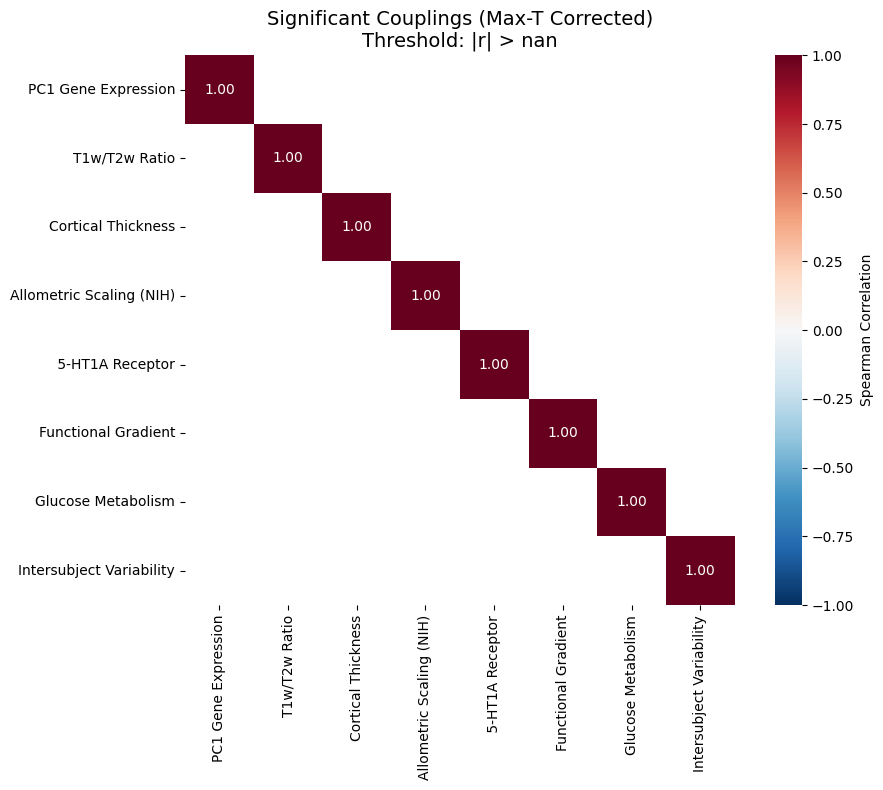

In [80]:
# Standard table
standard_table = generate_standard_comparison_table(df_corr_spearman, df_pvals_spearman)
display(standard_table)

# Run Max-T and get the specific table/plot
# Method = spearman below
maxt_table, threshold = compute_and_display_maxt(
    df_corr_spearman, 
    prepared_maps, 
    nulls_list, 
    method='spearman'
)

### Plotting Coupling Brain maps

In [ ]:
## Plotting coupling brain maps
# the ones that have curved relationships in the scatter plots

def generate_coupling_map(map1_data, map2_data):
    mask = (~np.isnan(map1_data)) & (~np.isnan(map2_data)) & (map1_data != 0) & (map2_data != 0)
    coupling_map = np.zeros_like(map1_data, dtype=float)
    
    d1 = map1_data[mask]
    d2 = map2_data[mask]

    # rank the data, compare diff units, but in the same coordiante system  
    r1 = rankdata(d1, method='average') / len(d1)
    r2 = rankdata(d2, method='average') / len(d2)
    # divide to normalize data 0 to 1
    diff = np.abs(r1 - r2)
    
    ## NEED TO CHECK FOR NEGATIVE RELATIONSHIP
    # gene exp and myelin are neg with func gradeint
    #cort thickness and func gradient are pos
    #5ht1a and func grad are pos

    # do a check to make sure 

# ['abagen_genepc1', 0
#  'hcps1200_myelinmap', 1
#  'hcps1200_thickness', 2
#  'reardon2018_scalingnih', 3
#  'savli2012_way100635', 4
#  'margulies2016_fcgradient01', 5
#  'raichle_cmrglc', 6
#  'mueller2013_intersubjvar'] 7
        
    
    coupling_score = 1.0 - (1.0 - diff)
    
    coupling_map[mask] = coupling_score
    return coupling_map


def generate_NEGATIVE_coupling_map(map1_data, map2_data):
    mask = (~np.isnan(map1_data)) & (~np.isnan(map2_data)) & (map1_data != 0) & (map2_data != 0)
    coupling_map = np.zeros_like(map1_data, dtype=float)
    
    d1 = map1_data[mask]
    d2 = map2_data[mask]

    # rank the data, compare diff units, but in the same coordiante system  
    r1 = rankdata(d1, method='average') / len(d1)
    r2 = rankdata(d2, method='average') / len(d2)
    # divide to normalize data 0 to 1
    diff = np.abs(r1 - r2)        
    
    coupling_score = 1.0 - diff
    
    coupling_map[mask] = coupling_score
    return coupling_map

def plot_coupling_map(coupling_map_data, space='fsLR', den='32k', title='Local Coupling Strength', cmap='magma'):
    from neuromaps.datasets import fetch_atlas
    from neuromaps import plotting
    
    # returns a dictionary with paths to the surface files
    atlas = fetch_atlas(space, den)
    surf_l = atlas['inflated'].L
    surf_r = atlas['inflated'].R
    
    # get L and R hemis
    n_vertices = len(coupling_map_data)
    mid_point = n_vertices // 2
    data_l = coupling_map_data[:mid_point]
    data_r = coupling_map_data[mid_point:]
    
    fig = plt.figure(figsize=(10, 4))
    
    vmin, vmax = 0, 1
    
    # left hemi
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    plotting.plot_surf(
        surf_mesh=surf_l,
        surf_map=data_l,
        hemi='left',
        view='lateral',
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        colorbar=False,
        axes=ax1,
        title='Left Hemisphere'
    )
    
    # right hemi
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    plotting.plot_surf(
        surf_mesh=surf_r,
        surf_map=data_r,
        hemi='right',
        view='lateral',
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        colorbar=False,
        axes=ax2,
        title='Right Hemisphere'
    )
    
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_clim(vmin, vmax)
    cbar = fig.colorbar(sm, ax=[ax1, ax2], shrink=0.6, location='right')
    cbar.set_label(f'{title}', fontsize=11)
    
    plt.suptitle(title, fontsize=14)
    plt.show()

In [82]:
map_names

['abagen_genepc1',
 'hcps1200_myelinmap',
 'hcps1200_thickness',
 'reardon2018_scalingnih',
 'savli2012_way100635',
 'margulies2016_fcgradient01',
 'raichle_cmrglc',
 'mueller2013_intersubjvar']

In [81]:
prepared_maps

[array([-0.14960021,  0.71435326,  0.5332251 , ..., -0.7673894 ,
        -0.7618149 , -0.73177356], shape=(64984,), dtype=float32),
 array([1.3455285, 1.3452077, 1.3974727, ..., 1.2362034, 1.2334827,
        1.2351799], shape=(64984,), dtype=float32),
 array([3.0777564, 2.034869 , 2.9712224, ..., 3.0268323, 3.047197 ,
        2.9889643], shape=(64984,), dtype=float32),
 array([1.1884882 , 0.81385535, 0.8314943 , ..., 1.2012281 , 1.1712425 ,
        1.2115377 ], shape=(64984,), dtype=float32),
 array([37.421368, 27.300804, 23.448963, ..., 44.939358, 44.68842 ,
        43.892735], shape=(64984,), dtype=float32),
 array([ 6.379188 , -4.9558477, -2.9024293, ...,  5.802551 ,  5.9602456,
         5.8580394], shape=(64984,), dtype=float32),
 array([7599.0854, 6243.808 , 6665.2417, ..., 6220.3965, 6168.7764,
        6209.3174], shape=(64984,), dtype=float32),
 array([0.58998483, 0.57853687, 0.6059104 , ..., 0.6446652 , 0.64774984,
        0.65093017], shape=(64984,), dtype=float32)]

In [84]:
    ## NEED TO CHECK FOR NEGATIVE RELATIONSHIP
    # gene exp and myelin are neg with func gradeint
    #cort thickness and func gradient are pos
    #5ht1a and func grad are pos

# ['abagen_genepc1', 0
#  'hcps1200_myelinmap', 1
#  'hcps1200_thickness', 2
#  'reardon2018_scalingnih', 3
#  'savli2012_way100635', 4
#  'margulies2016_fcgradient01', 5
#  'raichle_cmrglc', 6
#  'mueller2013_intersubjvar'] 7


Plotting coupling map: Myelin vs Gradient Coupling


/var/folders/ff/1nvxwnl16fs1my8jhytzdqxw0000gn/T/ipykernel_91540/3816988368.py:45: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.plot_surf(
/var/folders/ff/1nvxwnl16fs1my8jhytzdqxw0000gn/T/ipykernel_91540/3816988368.py:60: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.plot_surf(


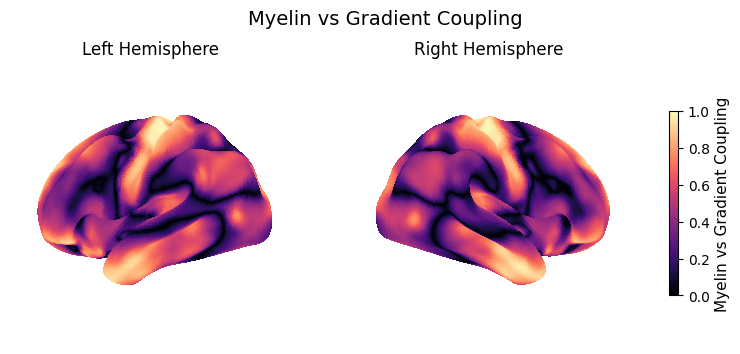

In [ ]:
idx_myelin = 1
idx_gradient = 5
map_A = prepared_maps[idx_myelin]
map_B = prepared_maps[idx_gradient]

coupling_brain = generate_NEGATIVE_coupling_map(map_A, map_B)

plot_coupling_map(coupling_brain, title='Myelin vs Gradient Coupling')

### Make Scatterplot with Ranked Data

In [85]:
def pairwise_rank_scatterplot(prepared_maps, map_names, readable_map_names=None):
    """
    Generates pairwise scatterplots using RANKED data.
    This visualizes the monotonic relationships (Spearman) by linearizing them.
    """
    print("--- Generating Pairwise RANK Scatterplots ---")
    
    # 1. Global Masking
    data_stack = np.column_stack(prepared_maps)
    global_mask = np.all((~np.isnan(data_stack)) & (data_stack != 0), axis=1)
    clean_data = data_stack[global_mask]
    
    # 2. Rank Transform the Data (Column-wise)
    # This converts raw values to ranks (0, 1, 2... N)
    ranked_data = np.apply_along_axis(rankdata, 0, clean_data)
    
    n_maps = len(prepared_maps)
    
    # Resolve names
    display_names = map_names
    if readable_map_names:
        display_names = []
        for name in map_names:
            if name in readable_map_names:
                display_names.append(readable_map_names[name])
                continue
            found_match = False
            for key, val in readable_map_names.items():
                if name.endswith(f"_{key}"):
                    display_names.append(val)
                    found_match = True
                    break
            if not found_match: display_names.append(name)

    # Setup Plot Grid
    import math
    n_pairs = (n_maps * (n_maps - 1)) // 2
    n_cols = 4
    n_rows = math.ceil(n_pairs / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
    axes = axes.flatten()
    
    plot_idx = 0
    
    for i in range(n_maps):
        for j in range(i + 1, n_maps):
            ax = axes[plot_idx]
            
            # Use RANKED data
            x = ranked_data[:, i]
            y = ranked_data[:, j]
            
            # Compute stats (On ranks, Pearson == Spearman)
            rho, _ = pearsonr(x, y) 
            
            # Hexbin Plot
            hb = ax.hexbin(x, y, gridsize=50, cmap='viridis', mincnt=1, bins='log')
            
            # Trendline
            z = np.polyfit(x, y, 1)
            p = np.poly1d(z)
            x_range = np.linspace(x.min(), x.max(), 100)
            ax.plot(x_range, p(x_range), "r--", alpha=0.8, linewidth=2)
            
            ax.set_xlabel(f"{display_names[i]} (Rank)", fontsize=8)
            ax.set_ylabel(f"{display_names[j]} (Rank)", fontsize=8)
            
            ax.set_title(f"Spearman ρ={rho:.2f}", fontsize=10, fontweight='bold')
            ax.set_xticks([])
            ax.set_yticks([])
            
            plot_idx += 1
        
    for k in range(plot_idx, len(axes)):
        axes[k].axis('off')
        
    plt.tight_layout()
    plt.show()

--- Generating Pairwise RANK Scatterplots ---


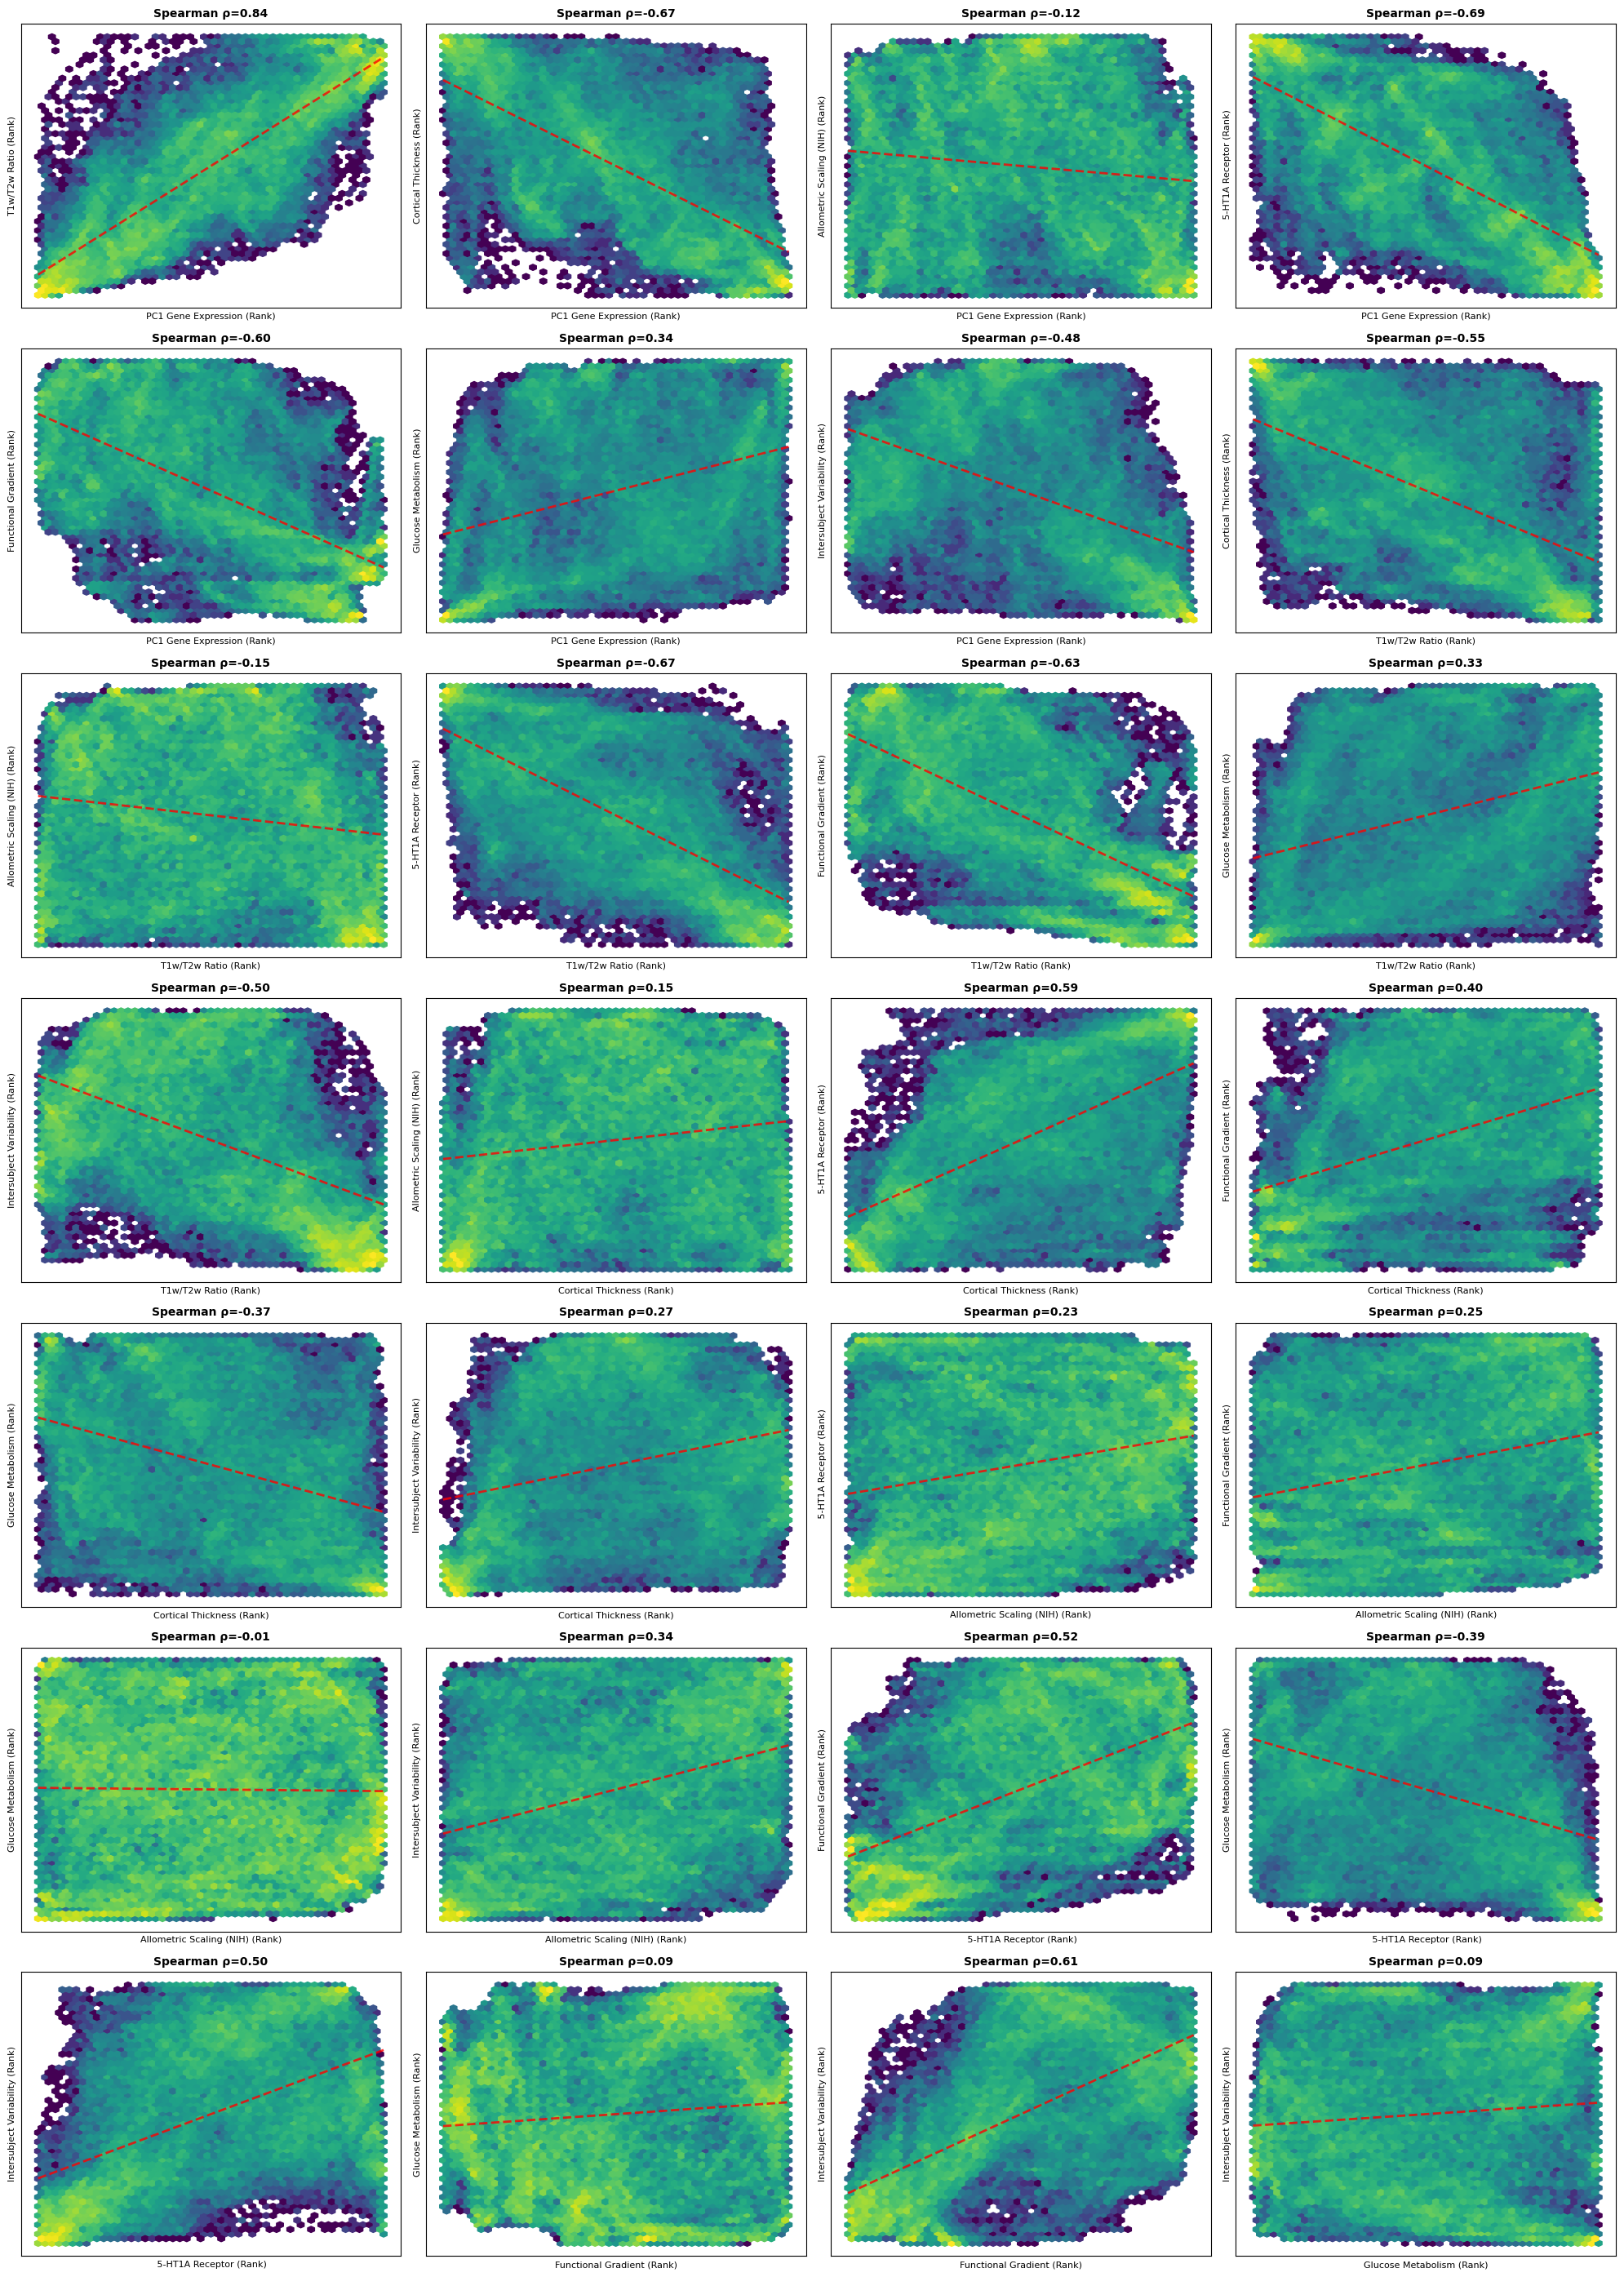

In [86]:
pairwise_rank_scatterplot(
    prepared_maps, 
    map_names, 
    readable_map_names=readable_map_names
)

# **What to look for:**
# * If your "Hockey Stick" curves from the previous plot turn into straight diagonal lines here, it confirms the relationship is **monotonic** and Spearman is the correct metric.
# * If they still look like blobs, there is no relationship.

Scenario A: Positive CorrelationLook for: A yellow cloud stretching from $(0,0)$ to $(30k, 30k)$.
Meaning: Low ranks go with low ranks; high ranks go with high ranks.

Scenario B: Negative CorrelationLook for: A yellow cloud stretching from Top-Left to Bottom-Right.Meaning: High ranks go with low ranks.

Scenario C: No CorrelationLook for: A diffuse yellow cloud in the center, or random yellow patches everywhere. No clear direction.

Yellow/Bright Green (High Density): This is where the points are most concentrated.

In a rank plot, this is your "trend line."

If the yellow blobs form a diagonal line (from bottom-left to top-right), it means Positive Correlation.

If they form a diagonal from top-left to bottom-right, it means Negative Correlation.


Dark Blue/Purple (Low Density): These are areas with fewer points.

If the whole square is dark blue with just a few random yellow spots, there is No Relationship.